In [1]:
#Import du script de comparaison
from Comparison_scripts.monte_carlo_compare import run_comparison
from Comparison_scripts.monte_carlo_compare import run_dl_model_comparison
from Signal_generator.generate_signal import *
import torch.nn.functional as F
from Algorithmes.music import estimate_angles
import numpy as np
import torch.nn as nn


In [2]:
class DeepMusicModel(nn.Module):
    def __init__(self, output_size):
        super(DeepMusicModel, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=256)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        
        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        
        # Assuming the spatial dimensions (height and width) are reduced to 1x1 after the convolutions
        # Define the fully connected layers
        self.fc1 = nn.Linear(in_features=20736, out_features=output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Softmax layer 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply the first convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Apply the second convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn2(self.conv2(x)))
        
        # Apply the third convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Apply the fourth convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Flatten the tensor for the fully connected layer
        x = torch.flatten(x, 1)
        
        # Apply the first fully connected layer
        x = self.fc1(x)
        
        # Apply the dropout layer
        x = self.dropout(x)

        #Apply the softmax layer
        x = self.softmax(x)
        
        return x

In [8]:
from Models.compare import *
models_deep_music1 = load_deep_music("DeepMusic_subregion_1", model_class=DeepMusicModel, outputs=[121])
models_deep_music2 = load_deep_music("DeepMusic_subregion_2", model_class=DeepMusicModel, outputs=[60, 61])

In [428]:
def reconstruct_music_spectrum(segments, Q, N):
    reconstructed_spectrum = np.zeros(N)
    
    for q, segment in enumerate(segments):
        start_index = q * (N // Q)
        end_index = (q + 1) * (N // Q) if q != Q - 1 else N

        # Détacher le tenseur du graphe de calcul et le convertir en un tableau numpy
        segment = segment.detach().numpy()
        reconstructed_spectrum[start_index:end_index] = segment

    return reconstructed_spectrum

def deep_music_pred_1(X, nbSensors, nbSources):
    # Générer la matrice R_hat_with_phase et la convertir en tenseur PyTorch
    input_tensor = torch.tensor(generate_R_hat_with_phase(X), dtype=torch.float32).unsqueeze(0)

    # Passer le modèle en mode évaluation et faire la prédiction
    models_deep_music1[0].eval()
    with torch.no_grad():
        a = models_deep_music1[0](input_tensor)

        # Détacher le tenseur du graphe de calcul et le convertir en tableau NumPy
        a_numpy = a.detach().cpu().numpy()

        # Estimer les angles à partir du spectre MUSIC
        estimated_angles = estimate_angles(nbSources, a_numpy, np.linspace(-60, 60, 121))

        return estimated_angles

def deep_music_pred_2(X, nbSensors, nbSources):
    input_tensor = torch.tensor(generate_R_hat_with_phase(X), dtype=torch.float32).unsqueeze(0)
    a = []
    models_deep_music2[0][0].eval()
    models_deep_music2[0][1].eval()
    with torch.no_grad():
        q1 = models_deep_music2[0][0](input_tensor)
        q2 = models_deep_music2[0][1](input_tensor)

        # Détacher le tenseur du graphe de calcul et le convertir en tableau NumPy
        q1_numpy = q1.detach().cpu().numpy()
        q2_numpy = q2.detach().cpu().numpy()

        a.append(q1)
        a.append(q2)

        # Estimer les angles à partir du spectre MUSIC
        a = reconstruct_music_spectrum(a, 2, 121)
        estimated_angles = estimate_angles(nbSources, a, np.linspace(-60, 60, 121))
    
    return estimate_angles(nbSources, a, np.linspace(-60, 60, 121))


In [429]:
models_deep_music2[0][0]

DeepMusicModel(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20736, out_features=60, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [430]:
# Algorithmes à importer
from Algorithmes.beamforming import beamforming_method
from Algorithmes.music import music_method

In [431]:
# Appel des algorithmes à comparer. clé: nom de l'algorithme, valeur: fonction de l'algorithme
# La fonction doit prendre en entrée les paramètres suivants: X, nbSensors, nbSources
# La fonction doit donner en sortie une liste de la forme [angleEstime1, angleEstime2] rangée dans l'ordre croissant
algorithms_to_compare = {
    "Beamforming": beamforming_method,
    "DeepMusic_subregions_1": deep_music_pred_1,
    "DeepMusic_subregions_2": deep_music_pred_2
}



In [432]:
nb_iterations = 100 # Nombre d'itérations de Monte Carlo pour chaque algorithme
nbSources = 2
nbSensors = 9
theta = [-20, 20] # Les deux angles d'origine des sources
two_symmetrical_angles = True # Si True, on a deux angles symétriques par rapport à 0.
# Favoriser de angles symmétriques : cela aura un effet similaire à doubler nb_itération sans doubler le temps de calcul

In [433]:
# Valeurs neutres pour les 5 paramètres à slider:
# nbTimePoints = 100
# var_ratio = [1] -> les deux signaux ont la même variance
# correlation = [0] -> les deux signaux sont indépendants
# snr = 10 -> le bruit est 10 fois plus petit que le signal
# perturbation_parameter_sd = 0 -> les capteurs sont parfaitement alignés

In [434]:
# Exemples de ranges intéressantes pour les paramètres à slider:
# var_ratio = [[1], [10], [50]]
# correlation = [[0], [0.9], [0.95], [0.99]]
# snr = [-10, -5, 0, 5, 10, 20]
# perturbation_parameter_sd = [0, 0.01, 0.1]

In [435]:
# IMPORTANT : le paramètre défini en temps que parameter_to_compare doit être sous forme d'une liste de valeurs. Exemples dans la cellule au dessus.
# Pour var_ratio et correlation, faites attention à bien avoir une liste de liste de réels s'ils sont en parameter_to_compare, et une liste de réels sinon.
nbTimePoints = 100
var_ratio = [1]
correlation = [0]
snr = [-10, 0, 10, 20]
perturbation_parameter_sd = 0

In [436]:
# Les parameter_to_compare valides sont: "snr", "nbTimePoints", "correlation", "var_ratio" et "perturbation_parameter_sd"
parameter_to_compare = "snr" # Paramètre à faire slider

Pour snr = -10 :
-----
Temps moyen d'estimation pour une itération de Beamforming: 0.0944 secondes
Beamforming: 10 outliers removed (10.00%)
Valeur pour Beamforming : 1.519064039320118
-----
Temps moyen d'estimation pour une itération de DeepMusic_subregions_1: 0.0050 secondes
DeepMusic_subregions_1: 99 outliers removed (99.00%)
Valeur pour DeepMusic_subregions_1 : 3.1622776601683795
-----
Temps moyen d'estimation pour une itération de DeepMusic_subregions_2: 0.0072 secondes
DeepMusic_subregions_2: 98 outliers removed (98.00%)
Valeur pour DeepMusic_subregions_2 : 3.427827300200522
-----
Valeur de la Cramer Rao Lower Bound : 0.00010035660340610062
--------------------------------
Pour snr = 0 :
-----
Temps moyen d'estimation pour une itération de Beamforming: 0.0938 secondes
Beamforming: 0 outliers removed (0.00%)
Valeur pour Beamforming : 0.3156738823532921
-----
Temps moyen d'estimation pour une itération de DeepMusic_subregions_1: 0.0048 secondes
DeepMusic_subregions_1: 99 outliers r

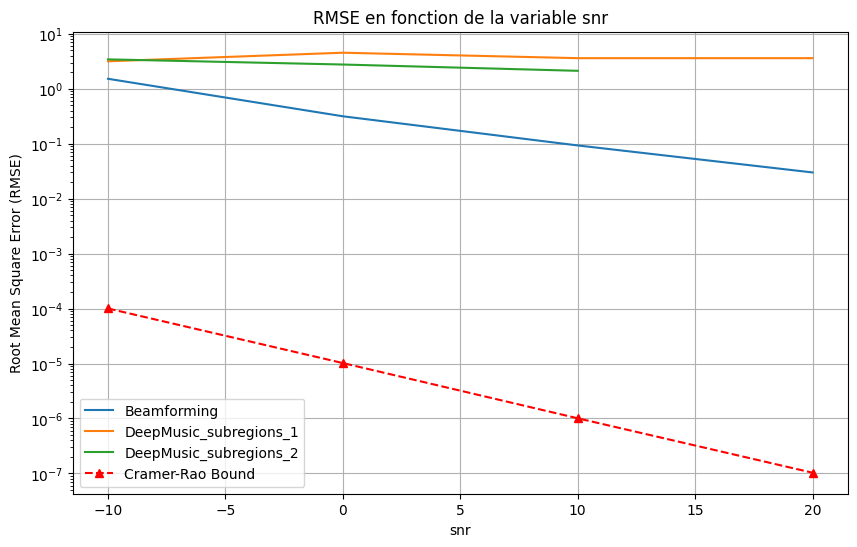

In [437]:
import torch.nn.functional as F

run_comparison(parameter_to_compare, algorithms_to_compare, nb_iterations, nbSources, nbSensors, theta, nbTimePoints, snr, correlation, var_ratio, perturbation_parameter_sd, two_symmetrical_angles)

In [485]:
from Signal_generator.generate_signal import generate_X_matrix

nbSources = 2 # Nombre de sources
nbSensors = 9 # Nombre de capteurs
nbTimePoints = 100 # Nombre de points temporels
signal_noise_ratio = 10 # Rapport signal sur bruit en décibels. Si 'False', cela revient à une absence totale de bruit.
theta1 = -45 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 1
theta2 = 45 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 2
var_ratio = [1] # Liste qui donne le rapport entre la variance du signal 1 et celui des autres sources (ex: [2, 3] signifie que la source 2 a une variance 2 fois plus grande que la source 1, et la source 3 a une variance 3 fois plus grande que la source 1)
correlation_List = [0] # Liste des corrélations. Il y a une corrélation nécéssaire pour chaque paire distincte de sources différentes: 0 pour 1 source, 1 pour 2 sources, 3 pour 3 sources, 6 pour 4 sources etc...
# Ordre de remplisage de la correlation_List: de gauche à droite et ligne par ligne, moitié haut-droite de la matrice uniquement, puis symétrie de ces valeurs pour la moitié bas-gauche
perturbation_parameter_sd = 0 # Écart-type de la distribution normale qui génère les erreurs de calibration des capteurs

thetaList = [theta1, theta2]
X = generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd)
print("DeepMusic_subregions_1 :", deep_music_pred_1(X, nbSensors, nbSources), "DeepMusic_subregions_2 : ", deep_music_pred_2(X, nbSensors, nbSources))

DeepMusic_subregions_1 : [-38. -36.] DeepMusic_subregions_2 :  [-15.  15.]


In [486]:
for i in range(20):
    print("DeepMusic_subregions_1 :", deep_music_pred_1(generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd), nbSensors, nbSources), "DeepMusic_subregions_2 : ", deep_music_pred_2(generate_X_matrix(nbSources, nbSensors, nbTimePoints, thetaList, var_ratio, correlation_List, signal_noise_ratio, perturbation_parameter_sd), nbSensors, nbSources))

DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-38.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-38.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-12.  15.]
DeepMusic_subregions_1 : [-36.  55.] DeepMusic_subregions_2 :  [-15.  15.]
DeepMusic_subregions_1 : 